In [1]:
import numpy as np
from tsai.all import *
import sklearn.metrics as skm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [3]:
num_epochs = 100
few_shot_patience = 3

In [4]:
df = pd.read_pickle('togzhan_data_labeled.pkl').reset_index(drop=True)
df['Trial ID'] = df['Person No'].astype(str) + '_' + df['Trial No'].astype(str)



# Create new columns for labels in both datasets
df['Lump'] = df['Type'].apply(lambda x: 1 if x < 9 else 0)
df['Size'] = df['Type'].apply(lambda x: 0 if x in [0, 1, 2] else (1 if x in [3, 4, 5] else (2 if x in [6, 7, 8] else 3)))
df['Position'] = df['Type'].apply(lambda x: 0 if x in [0, 3, 6] else (1 if x in [1, 4, 7] else (2 if x in [2, 5, 8] else 3)))

# Split trials into train, validation, and test sets ensuring user independence
unique_persons = df['Person No'].unique()
train_persons, test_persons = train_test_split(unique_persons, test_size=0.1, random_state=seed)
train_persons, valid_persons = train_test_split(train_persons, test_size=0.2, random_state=seed)

train_mask = df['Person No'].isin(train_persons)
valid_mask = df['Person No'].isin(valid_persons)
test_mask = df['Person No'].isin(test_persons)
train_df = df[train_mask]
valid_df = df[valid_mask]
test_df = df[test_mask]

In [5]:
df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump,Size,Position
0,0,0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...]",1,0_0,1,0,0
1,0,0,1,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...]",1,0_1,1,0,0
2,0,0,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...]",1,0_2,1,0,0
3,0,0,3,"[1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...]",1,0_3,1,0,0
4,0,0,4,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",1,0_4,1,0,0
...,...,...,...,...,...,...,...,...,...
5755,9,12,67,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 4.0, 4.0, 6.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 8.0, 10.0, 10.0, 9.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 11.0, 12.0, 12.0, 10.0, 10.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 1.0, 1.0, 2.0, ...]",0,9_67,0,3,3
5756,9,12,68,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 4.0, 4.0, 5.0, 5.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 9.0, 9.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 8.0, 8.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 2.0, 2.0, 4.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",0,9_68,0,3,3
5757,9,12,69,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [6]:
train_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump,Size,Position
0,0,0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...]",1,0_0,1,0,0
1,0,0,1,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...]",1,0_1,1,0,0
2,0,0,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...]",1,0_2,1,0,0
3,0,0,3,"[1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...]",1,0_3,1,0,0
4,0,0,4,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",1,0_4,1,0,0
...,...,...,...,...,...,...,...,...,...
5467,8,12,67,"[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 5.0, 5.0, 3.0, 2.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 6.0, 6.0, ...]",0,8_67,0,3,3
5468,8,12,68,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 5.0, 6.0, 6.0, 7.0, 7.0, 8.0, 8.0, 8.0, 10.0, 9.0, 9.0, 10.0, ...]",0,8_68,0,3,3
5469,8,12,69,"[4.0, 4.0, 5.0, 6.0, 6.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 11.0, 11.0, 12.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 11.0, 10.0, 10.0, 12.0, 9.0,

In [7]:
valid_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump,Size,Position
2016,7,0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 5.0, 5.0, 7.0, 6.0, 6.0, 8.0, 8.0, 7.0, 9.0, 9.0, 9.0, 11.0, 11.0, 10.0, 10.0, ...]",1,7_0,1,0,0
2017,7,0,1,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 8.0, 8.0, 6.0, 6.0, 7.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 11.0, 11.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 6.0, 6.0, 6.0, 7.0, 7.0, 5.0, 4.0, 4.0, 3.0, 1.0, 1.0, 0.0, 0.0, 2.0, 3.0, 3.0, 3.0, ...]",1,7_1,1,0,0
2018,7,0,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 5.0, 4.0, 2.0, 2.0, 4.0, 3.0, 3.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 4.0, 5.0, 5.0, 6.0, 6.0, 7.0, 8.0, 8.0, 9.0, 10.0, 10.0, 10.0, 10.0, 12.0, 10.0, 10.0, 9.0, 7.0, ...]",1,7_2,1,0,0
2019,7,0,3,"[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, ...]",1,7_3,1,0,0
2020,7,0,4,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 2.0, 3.0, 2.0, 2.0, 1.0, ...]",1,7_4,1,0,0
...,...,...,...,...,...,...,...,...,...
5755,9,12,67,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 4.0, 4.0, 6.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 8.0, 10.0, 10.0, 9.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 11.0, 12.0, 12.0, 10.0, 10.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 1.0, 1.0, 2.0, ...]",0,9_67,0,3,3
5756,9,12,68,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 4.0, 4.0, 5.0, 5.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 9.0, 9.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 8.0, 8.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 2.0, 2.0, 4.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",0,9_68,0,3,3
5757,9,12,69,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.

In [8]:
test_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump,Size,Position
1728,6,0,0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...]",1,6_0,1,0,0
1729,6,0,1,"[3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 3.0, 3.0, 4.0, 7.0, 7.0, 10.0, 11.0, 11.0, 11.0, 11.0, 10.0, 11.0, 11.0, 12.0, 16.0, 16.0, 21.0, 21.0, 22.0, 21.0, 21.0, 18.0, 16.0, 16.0, 14.0, 14.0, 16.0, 19.0, 19.0, 22.0, 24.0, 24.0, 25.0, 25.0, 26.0, 29.0, 29.0, 34.0, 41.0, 41.0, 45.0, 45.0, 48.0, 50.0, 50.0, 48.0, 47.0, 47.0, 45.0, 45.0, 44.0, 42.0, 42.0, 41.0, 39.0, 39.0, 37.0, 37.0, 34.0, 28.0, 28.0, 20.0, 17.0, 17.0, 13.0, 13.0, 13.0, 16.0, 16.0, 21.0, 22.0, 22.0, 20.0, 20.0, 19.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 15.0, 15.0, 15.0, 17.0, 17.0, 18.0, 18.0, ...]",1,6_1,1,0,0
1730,6,0,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...]",1,6_2,1,0,0
1731,6,0,3,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...]",1,6_3,1,0,0
1732,6,0,4,"[3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, ...]",1,6_4,1,0,0
...,...,...,...,...,...,...,...,...,...
4891,6,12,67,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",0,6_67,0,3,3
4892,6,12,68,"[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...]",0,6_68,0,3,3
4893,6,12,69,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [9]:
hashable_columns = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, (str, int, float, bool))).all()]

# Check for duplicate rows within each dataframe
train_duplicates = train_df.duplicated(subset=hashable_columns).sum()
valid_duplicates = valid_df.duplicated(subset=hashable_columns).sum()
test_duplicates = test_df.duplicated(subset=hashable_columns).sum()

# Check for overlapping rows between the dataframes
overlap_train_valid = pd.merge(train_df, valid_df, how='inner', on=hashable_columns)
overlap_train_test = pd.merge(train_df, test_df, how='inner', on=hashable_columns)
overlap_valid_test = pd.merge(valid_df, test_df, how='inner', on=hashable_columns)

print("Duplicate rows in train_df:", train_duplicates)
print("Duplicate rows in valid_df:", valid_duplicates)
print("Duplicate rows in test_df:", test_duplicates)
print("Overlapping rows between train_df and valid_df:", overlap_train_valid.shape[0])
print("Overlapping rows between train_df and test_df:", overlap_train_test.shape[0])
print("Overlapping rows between valid_df and test_df:", overlap_valid_test.shape[0])


Duplicate rows in train_df: 0
Duplicate rows in valid_df: 0
Duplicate rows in test_df: 0
Overlapping rows between train_df and valid_df: 0
Overlapping rows between train_df and test_df: 0
Overlapping rows between valid_df and test_df: 0


In [8]:
def split_sensors(data, sensor_indices, num_seconds):
    data = np.array(data).reshape(-1, 15, 1120)
    selected_data = data[:, sensor_indices, :num_seconds * 160]
    return selected_data

def prepare_multitask_datasets(train_df, valid_df, test_df, sensor_indices, num_seconds):
    X_train = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in train_df['Data'].values], axis=0)
    y_train_lump = train_df['Lump'].values
    y_train_size = train_df['Size'].values
    y_train_position = train_df['Position'].values

    X_valid = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in valid_df['Data'].values], axis=0)
    y_valid_lump = valid_df['Lump'].values
    y_valid_size = valid_df['Size'].values
    y_valid_position = valid_df['Position'].values

    X_test = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in test_df['Data'].values], axis=0)
    y_test_lump = test_df['Lump'].values
    y_test_size = test_df['Size'].values
    y_test_position = test_df['Position'].values

    return (X_train, y_train_lump, y_train_size, y_train_position), (X_valid, y_valid_lump, y_valid_size, y_valid_position), (X_test, y_test_lump, y_test_size, y_test_position)


In [9]:
class MultitaskInceptionTime(nn.Module):
    def __init__(self, input_channels, num_classes_lump, num_classes_size, num_classes_position):
        super(MultitaskInceptionTime, self).__init__()
        self.inception_time = InceptionTime(input_channels, 256)  # Adjust the output size
        self.fc_lump = nn.Linear(256, num_classes_lump)
        self.fc_size = nn.Linear(256, num_classes_size)
        self.fc_position = nn.Linear(256, num_classes_position)

    def forward(self, x):
        x = self.inception_time(x)
        lump_out = self.fc_lump(x)
        size_out = self.fc_size(x)
        position_out = self.fc_position(x)
        return lump_out, size_out, position_out

def combined_loss(lump_out, size_out, position_out, y_lump, y_size, y_position):
    criterion_lump = nn.CrossEntropyLoss()
    criterion_size = nn.CrossEntropyLoss()
    criterion_position = nn.CrossEntropyLoss()
    
    loss_lump = criterion_lump(lump_out, y_lump)
    loss_size = criterion_size(size_out, y_size)
    loss_position = criterion_position(position_out, y_position)
    
    return loss_lump + loss_size + loss_position

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def train_multitask_model(sensor_indices, num_seconds, train_df, valid_df, test_df):
    (X_train, y_train_lump, y_train_size, y_train_position), (X_valid, y_valid_lump, y_valid_size, y_valid_position), (X_test, y_test_lump, y_test_size, y_test_position) = prepare_multitask_datasets(train_df, valid_df, test_df, sensor_indices, num_seconds)
    
    # Create DataLoaders
    def create_dataloader(X, y_lump, y_size, y_position, batch_size=32):
        ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y_lump, dtype=torch.long), torch.tensor(y_size, dtype=torch.long), torch.tensor(y_position, dtype=torch.long))
        return DataLoader(ds, batch_size=batch_size, shuffle=True)
    
    train_dl = create_dataloader(X_train, y_train_lump, y_train_size, y_train_position)
    valid_dl = create_dataloader(X_valid, y_valid_lump, y_valid_size, y_valid_position, batch_size=32)
    test_dl = create_dataloader(X_test, y_test_lump, y_test_size, y_test_position, batch_size=32)

    # Define model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultitaskInceptionTime(input_channels=X_train.shape[1], num_classes_lump=2, num_classes_size=4, num_classes_position=4)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    train_losses = []
    valid_losses = []

    def train_and_evaluate():
        nonlocal best_val_loss, patience_counter
        for epoch in range(num_epochs):  # Number of epochs
            model.train()
            running_loss = 0.0
            for x_batch, y_batch_lump, y_batch_size, y_batch_position in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
                x_batch, y_batch_lump, y_batch_size, y_batch_position = x_batch.to(device), y_batch_lump.to(device), y_batch_size.to(device), y_batch_position.to(device)
                optimizer.zero_grad()
                lump_out, size_out, position_out = model(x_batch)
                loss = combined_loss(lump_out, size_out, position_out, y_batch_lump, y_batch_size, y_batch_position)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            train_losses.append(running_loss / len(train_dl))
            
            # Validation
            model.eval()
            valid_loss = 0.0
            with torch.no_grad():
                for x_batch, y_batch_lump, y_batch_size, y_batch_position in valid_dl:
                    x_batch, y_batch_lump, y_batch_size, y_batch_position = x_batch.to(device), y_batch_lump.to(device), y_batch_size.to(device), y_batch_position.to(device)
                    lump_out, size_out, position_out = model(x_batch)
                    loss = combined_loss(lump_out, size_out, position_out, y_batch_lump, y_batch_size, y_batch_position)
                    valid_loss += loss.item()
            
            valid_losses.append(valid_loss / len(valid_dl))

            print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_dl):.4f}, Validation Loss: {valid_loss/len(valid_dl):.4f}")

            # Early stopping
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    def test_model(data_dl):
        model.eval()
        y_true_lump = []
        y_pred_lump = []
        y_true_size = []
        y_pred_size = []
        y_true_position = []
        y_pred_position = []
        
        with torch.no_grad():
            for x_batch, y_batch_lump, y_batch_size, y_batch_position in tqdm(data_dl, desc="Testing", leave=False):
                x_batch, y_batch_lump, y_batch_size, y_batch_position = x_batch.to(device), y_batch_lump.to(device), y_batch_size.to(device), y_batch_position.to(device)
                lump_out, size_out, position_out = model(x_batch)
                _, predicted_lump = torch.max(lump_out, 1)
                _, predicted_size = torch.max(size_out, 1)
                _, predicted_position = torch.max(position_out, 1)
                
                y_true_lump.extend(y_batch_lump.cpu().tolist())
                y_pred_lump.extend(predicted_lump.cpu().tolist())
                y_true_size.extend(y_batch_size.cpu().tolist())
                y_pred_size.extend(predicted_size.cpu().tolist())
                y_true_position.extend(y_batch_position.cpu().tolist())
                y_pred_position.extend(predicted_position.cpu().tolist())

        # Calculate metrics
        accuracy_lump = skm.accuracy_score(y_true_lump, y_pred_lump)
        accuracy_size = skm.accuracy_score(y_true_size, y_pred_size)
        accuracy_position = skm.accuracy_score(y_true_position, y_pred_position)
        
        print(f"Test Accuracy - Lump: {accuracy_lump:.4f}, Size: {accuracy_size:.4f}, Position: {accuracy_position:.4f}")
        
        print("\nConfusion Matrix - Lump:")
        cm_lump = confusion_matrix(y_true_lump, y_pred_lump)
        print(cm_lump)
        plot_confusion_matrix(cm_lump, classes=['No Lump', 'Lump'], title='Confusion Matrix - Lump')
        
        print("\nClassification Report - Lump:")
        print(classification_report(y_true_lump, y_pred_lump, target_names=['No Lump', 'Lump']))
        
        print("\nConfusion Matrix - Size:")
        cm_size = confusion_matrix(y_true_size, y_pred_size)
        print(cm_size)
        plot_confusion_matrix(cm_size, classes=['Small', 'Medium', 'Big', 'No Lump'], title='Confusion Matrix - Size')
        
        print("\nClassification Report - Size:")
        print(classification_report(y_true_size, y_pred_size, target_names=['Small', 'Medium', 'Big', 'No Lump']))
        
        print("\nConfusion Matrix - Position:")
        cm_position = confusion_matrix(y_true_position, y_pred_position)
        print(cm_position)
        plot_confusion_matrix(cm_position, classes=['Top', 'Middle', 'Bottom', 'No Lump'], title='Confusion Matrix - Position')
        
        print("\nClassification Report - Position:")
        print(classification_report(y_true_position, y_pred_position, target_names=['Top', 'Middle', 'Bottom', 'No Lump']))
        
        return accuracy_lump, accuracy_size, accuracy_position

    # Initial training and evaluation
    print("Initial Training and Evaluation:")
    train_and_evaluate()
    accuracies = test_model(test_dl)

    # Plotting learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

    return accuracies

In [10]:
sensor_indices = list(range(15))  # Using all 15 sensors
num_seconds = 7  # Using 7 seconds duration

Using 2 GPUs
Initial Training and Evaluation:


Epoch 1, Training Loss: 2.5044, Validation Loss: 3.2769


Epoch 2, Training Loss: 2.2682, Validation Loss: 3.4316


Epoch 3, Training Loss: 2.1579, Validation Loss: 3.2397


Epoch 4, Training Loss: 2.1265, Validation Loss: 2.9736


Epoch 5, Training Loss: 2.0464, Validation Loss: 3.6144


Epoch 6, Training Loss: 2.0289, Validation Loss: 3.6016


Epoch 7, Training Loss: 1.9256, Validation Loss: 3.1571


Epoch 8, Training Loss: 1.8865, Validation Loss: 3.5439


Epoch 9, Training Loss: 1.8479, Validation Loss: 3.6087
Early stopping at epoch 9


Test Accuracy - Lump: 0.4601, Size: 0.2170, Position: 0.2986

Confusion Matrix - Lump:
[[ 73 215]
 [ 96 192]]


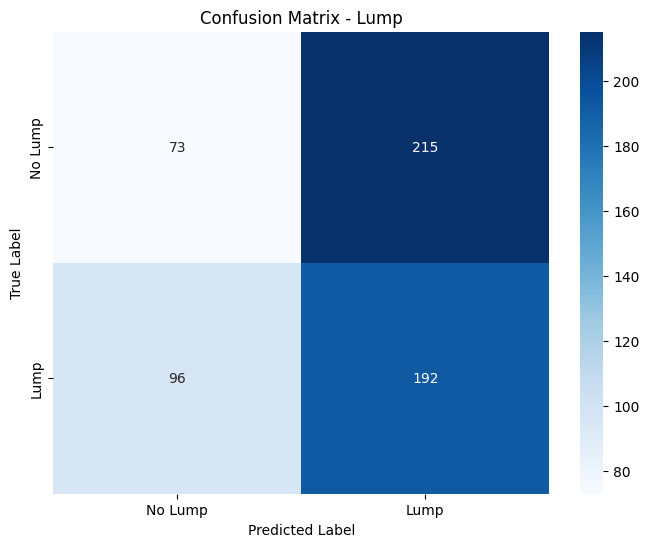


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.43      0.25      0.32       288
        Lump       0.47      0.67      0.55       288

    accuracy                           0.46       576
   macro avg       0.45      0.46      0.44       576
weighted avg       0.45      0.46      0.44       576


Confusion Matrix - Size:
[[ 16  13   4  63]
 [ 13  18   9  56]
 [ 22  62   1  11]
 [ 44 143  11  90]]


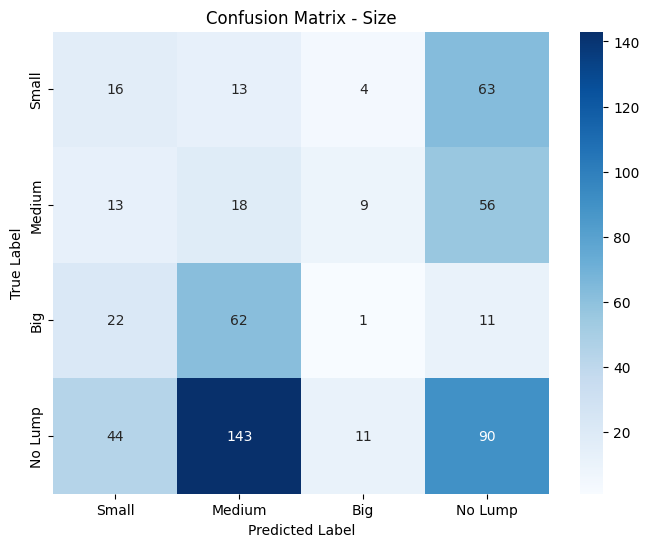


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.17      0.17      0.17        96
      Medium       0.08      0.19      0.11        96
         Big       0.04      0.01      0.02        96
     No Lump       0.41      0.31      0.35       288

    accuracy                           0.22       576
   macro avg       0.17      0.17      0.16       576
weighted avg       0.25      0.22      0.23       576


Confusion Matrix - Position:
[[ 40   9  17  30]
 [ 23   4  10  59]
 [ 15  10  31  40]
 [143  11  37  97]]


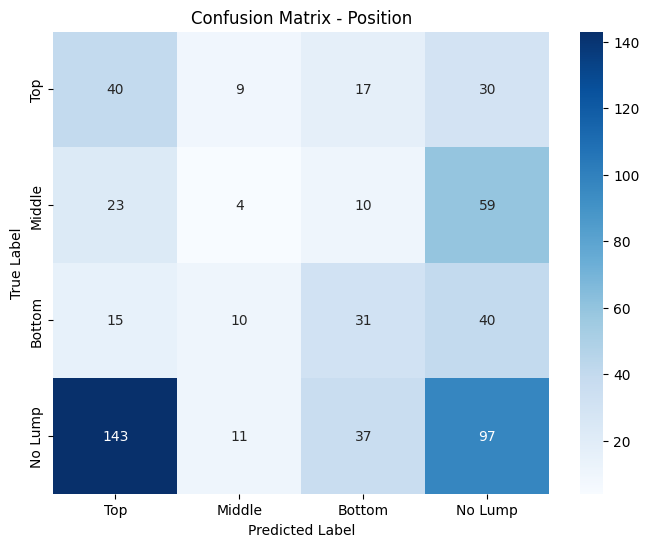


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.18      0.42      0.25        96
      Middle       0.12      0.04      0.06        96
      Bottom       0.33      0.32      0.32        96
     No Lump       0.43      0.34      0.38       288

    accuracy                           0.30       576
   macro avg       0.26      0.28      0.25       576
weighted avg       0.32      0.30      0.30       576



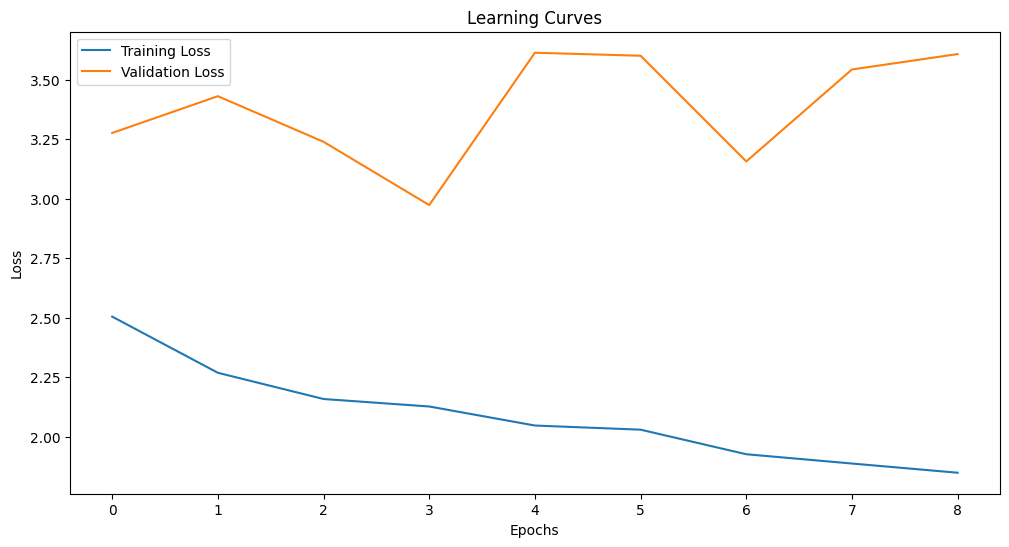

In [12]:
accuracies = train_multitask_model(sensor_indices, num_seconds, train_df, valid_df, test_df)